Step 1: Import Required Libraries

First, ensure you have the necessary libraries installed and imported.

In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


Step 2: Load and Preprocess the Data

Combine Customers.csv and Transactions.csv to create a feature-rich dataset.

1 Load Data

In [8]:


# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets
merged_data = pd.merge(transactions, customers, on='CustomerID', how='left')

# Aggregate transaction data for each customer
customer_features = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'nunique'),
    avg_spent_per_transaction=('TotalValue', 'mean')
).reset_index()

# Add customer demographic information
customer_features = pd.merge(customer_features, customers[['CustomerID', 'Region']], on='CustomerID', how='left')


2 Feature Engineering Normalize numeric features and encode categorical features.

In [9]:
# Normalize numeric features
scaler = StandardScaler()
customer_features[['total_spent', 'num_transactions', 'avg_spent_per_transaction']] = scaler.fit_transform(
    customer_features[['total_spent', 'num_transactions', 'avg_spent_per_transaction']]
)

# One-hot encode categorical features (Region)
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Drop CustomerID for clustering
clustering_data = customer_features.drop('CustomerID', axis=1)


Step 3: Apply Clustering

Use K-Means Clustering to segment the customers.

1 Choose the Number of Clusters Use the Elbow Method to determine the optimal number of clusters.

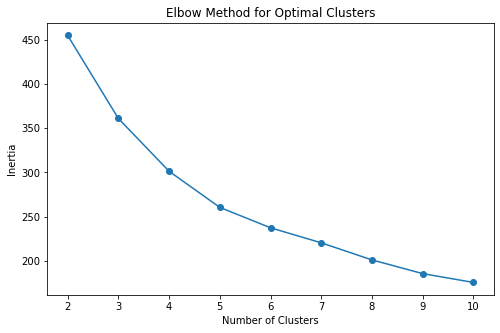

In [10]:
# Calculate inertia for different cluster sizes
inertias = []
cluster_range = range(2, 11)  # Clusters from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertias, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


2 Fit K-Means Choose the optimal number of clusters based on the elbow plot and fit the K-Means model.

In [11]:
# Set the optimal number of clusters (based on the elbow plot)
optimal_clusters = 4  # Example: Assume 4 from the elbow method

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(clustering_data)


Step 4: Evaluate Clustering

Use metrics like Davies-Bouldin Index (DB Index) and Silhouette Score to assess clustering quality.

In [12]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(clustering_data, customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Calculate Silhouette Score
silhouette_avg = silhouette_score(clustering_data, customer_features['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")


Davies-Bouldin Index: 1.2671328824141699
Silhouette Score: 0.23940179382264354


Step 5: Visualize the Clusters

Use dimensionality reduction techniques like PCA or t-SNE to visualize clusters in 2D.

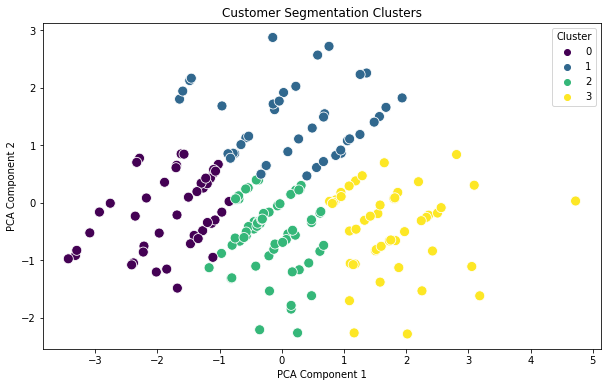

In [13]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_data = pca.fit_transform(clustering_data)

# Create a DataFrame for visualization
visual_data = pd.DataFrame(pca_data, columns=['PCA1', 'PCA2'])
visual_data['Cluster'] = customer_features['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visual_data, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segmentation Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


Step 6: Interpret the Clusters

Summarize the characteristics of each cluster:

    Compute average values for each feature by cluster.
    Describe how clusters differ (e.g., high spenders, frequent buyers, etc.).

In [14]:
# Summarize cluster characteristics
cluster_summary = customer_features.groupby('Cluster').mean()
print(cluster_summary)


         total_spent  num_transactions  avg_spent_per_transaction  \
Cluster                                                             
0          -1.161066         -1.004603                  -0.919502   
1           0.042048         -0.643690                   1.234822   
2          -0.191601          0.238626                  -0.470829   
3           1.297441          1.223639                   0.338267   

         Region_Europe  Region_North America  Region_South America  
Cluster                                                             
0             0.355556              0.177778              0.266667  
1             0.318182              0.204545              0.227273  
2             0.161290              0.338710              0.322581  
3             0.208333              0.166667              0.354167  
